<a href="https://colab.research.google.com/github/ekrell/icore_temp/blob/main/lagunamadre_wind_air.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Laguna Madre Wind & Air Tempurature

- ATP: air temperature (celsius)
  - Source: Packery
- WTP: water temperature (celsius)
  - Source: NPS-SBI


- Years: 2012-2020, 2022
- Resolution: hourly


https://www.sciencedirect.com/science/article/pii/S2352340923008909

# Setup

**Libraries**

In [ ]:
from google.colab.output import eval_js
import numpy as np
import pandas as pd
import urllib.request
import matplotlib.pyplot as plt
import scipy.stats
import statsmodels as sm
from statsmodels.graphics import tsaplots
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import spearmanr
import keras
import tensorflow as tf
from sklearn.inspection import permutation_importance
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
import seaborn as sns

**Options**

In [ ]:
# Years to include  (the last year will be used for testing)
selected_years = np.array([2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])

# Hours to predict in the future
lead_time_hours = 12

**Download data**

In [ ]:
remote_directory = "https://raw.githubusercontent.com/conrad-blucher-institute/LagunaMadreWaterAirTempDataCleaner/main/imputed_data"
file_format = "atp_and_wtp_{}.csv"

data_files_remote = [
    remote_directory + "/" + file_format.format(str(year)) \
     for year in selected_years
]

data_files = ["temperature_{}.csv".format(str(year)) for year in selected_years]

for i in range(len(data_files)):
  urllib.request.urlretrieve(data_files_remote[i], data_files[i])

!ls

sample_data	      temperature_2014.csv  temperature_2017.csv  temperature_2020.csv
temperature_2012.csv  temperature_2015.csv  temperature_2018.csv  temperature_2021.csv
temperature_2013.csv  temperature_2016.csv  temperature_2019.csv  temperature_2022.csv


In [ ]:
df = pd.concat(map(pd.read_csv, data_files))

df.rename(columns={'dateAndTime'           : 'datetime',
                   'packeryATP_lighthouse' : 'atp',
                   'npsbiWTP_lighthouse'   : 'wtp'}, inplace=True)

df['datetime'] = pd.to_datetime(df["datetime"])
df = df.set_index('datetime')

df

atp   wtp
datetime                       
2012-01-01 00:00:00  18.8  17.7
2012-01-01 01:00:00  18.9  17.6
2012-01-01 02:00:00  18.7  17.5
2012-01-01 03:00:00  19.7  17.4
2012-01-01 04:00:00  18.7  17.4
...                   ...   ...
2022-12-31 19:00:00  19.8  16.5
2022-12-31 20:00:00  22.3  16.8
2022-12-31 21:00:00  21.4  17.4
2022-12-31 22:00:00  21.8  17.6
2022-12-31 23:00:00  19.1  17.1

[96432 rows x 2 columns]

# Data Investigation

In [ ]:
df.describe()

atp           wtp
count  94936.000000  96022.000000
mean      22.634717     23.681663
std        6.280913      6.311580
min       -6.600000      1.300000
25%       18.900000     19.000000
50%       24.000000     25.000000
75%       27.900000     29.100000
max       34.900000     34.600000

### Time series

Text(0, 0.5, 'Celsius')

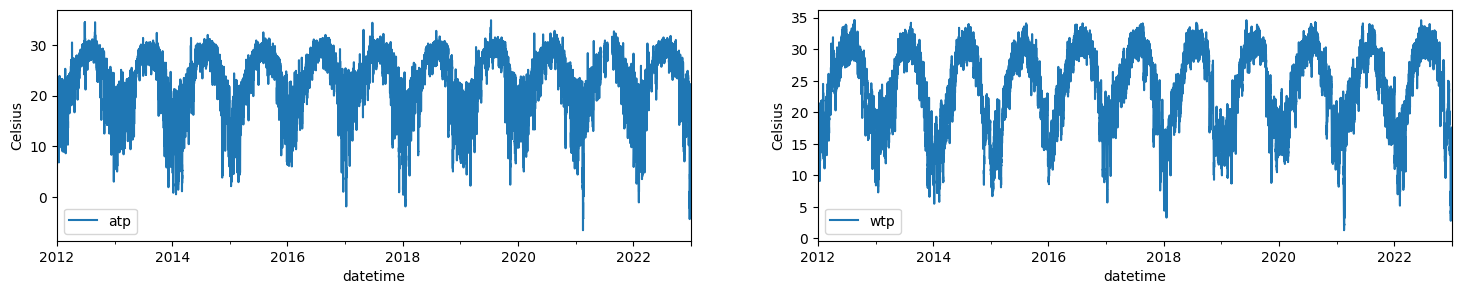

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18,3))

df.plot(y='atp', ax=axs[0])
df.plot(y="wtp", ax=axs[1])

axs[0].set_ylabel("Celsius")
axs[1].set_ylabel("Celsius")

<ipython-input-8-a5a358d4e4d4>:3: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample("M").max().plot(y="atp", ax=axs[0])
<ipython-input-8-a5a358d4e4d4>:4: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample("M").max().plot(y="wtp", ax=axs[1])
<ipython-input-8-a5a358d4e4d4>:6: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample("M").mean().plot(y="atp", ax=axs[0])
<ipython-input-8-a5a358d4e4d4>:7: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample("M").mean().plot(y="wtp", ax=axs[1])
<ipython-input-8-a5a358d4e4d4>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  df.resample("M").min().plot(y="atp", ax=axs[0])
<ipython-input-8-a5a358d4e4d4>:10: FutureWarning: 'M' is deprecated and will be rem

Text(0, 0.5, 'Celsius')

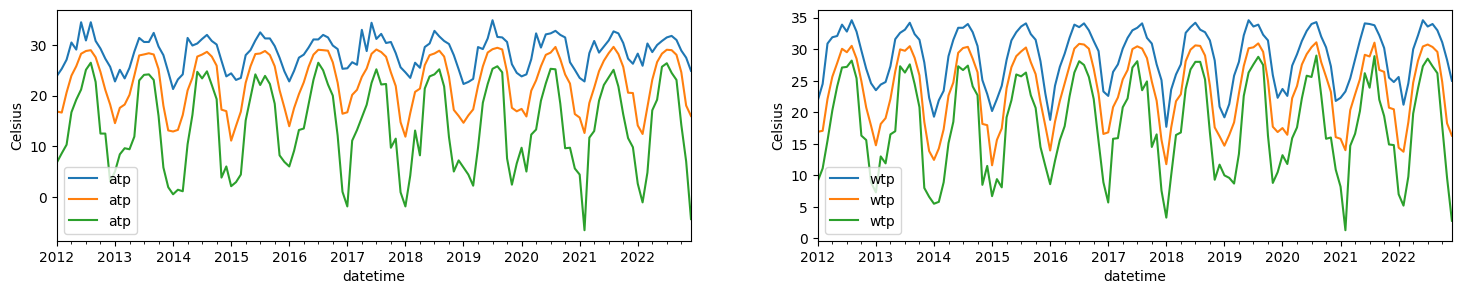

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18,3))

df.resample("M").max().plot(y="atp", ax=axs[0])
df.resample("M").max().plot(y="wtp", ax=axs[1])

df.resample("M").mean().plot(y="atp", ax=axs[0])
df.resample("M").mean().plot(y="wtp", ax=axs[1])

df.resample("M").min().plot(y="atp", ax=axs[0])
df.resample("M").min().plot(y="wtp", ax=axs[1])

axs[0].set_ylabel("Celsius")
axs[1].set_ylabel("Celsius")

**Monthly summaries**

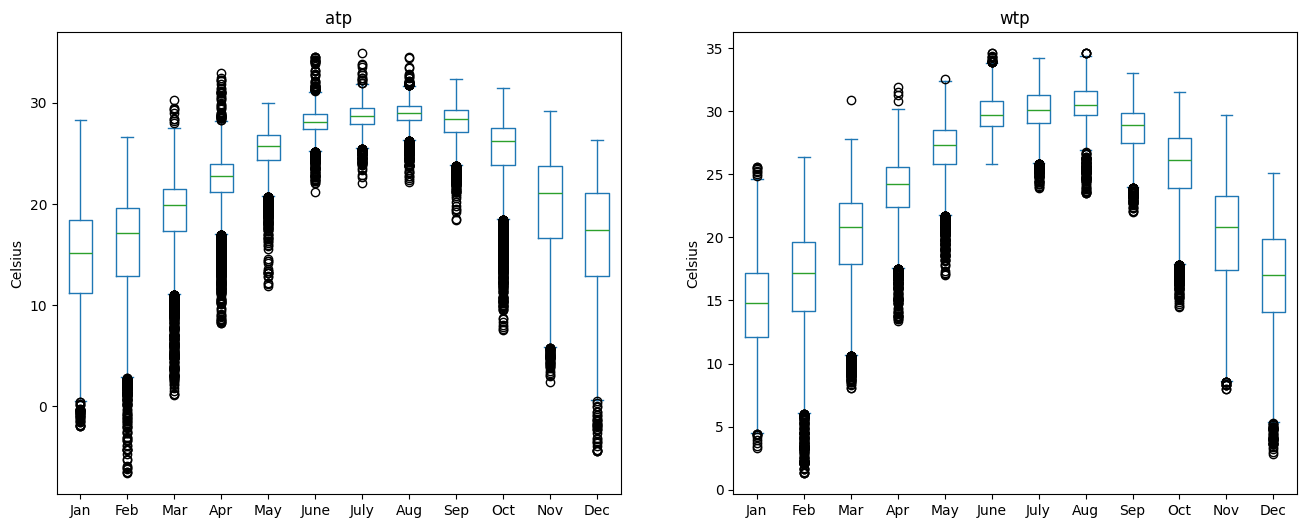

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))

df.set_index(df.index.month, append=True)['atp'].unstack().plot.box(ax=axs[0])
df.set_index(df.index.month, append=True)['wtp'].unstack().plot.box(ax=axs[1])

axs[0].set_ylabel("Celsius")
axs[1].set_ylabel("Celsius")

axs[0].set_title("atp")
axs[1].set_title("wtp")

months = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]
axs[0].set_xticklabels(months);
axs[1].set_xticklabels(months);

<ipython-input-10-c29ee58fbf9e>:13: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[0].set_xticklabels(months);
<ipython-input-10-c29ee58fbf9e>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1].set_xticklabels(months);


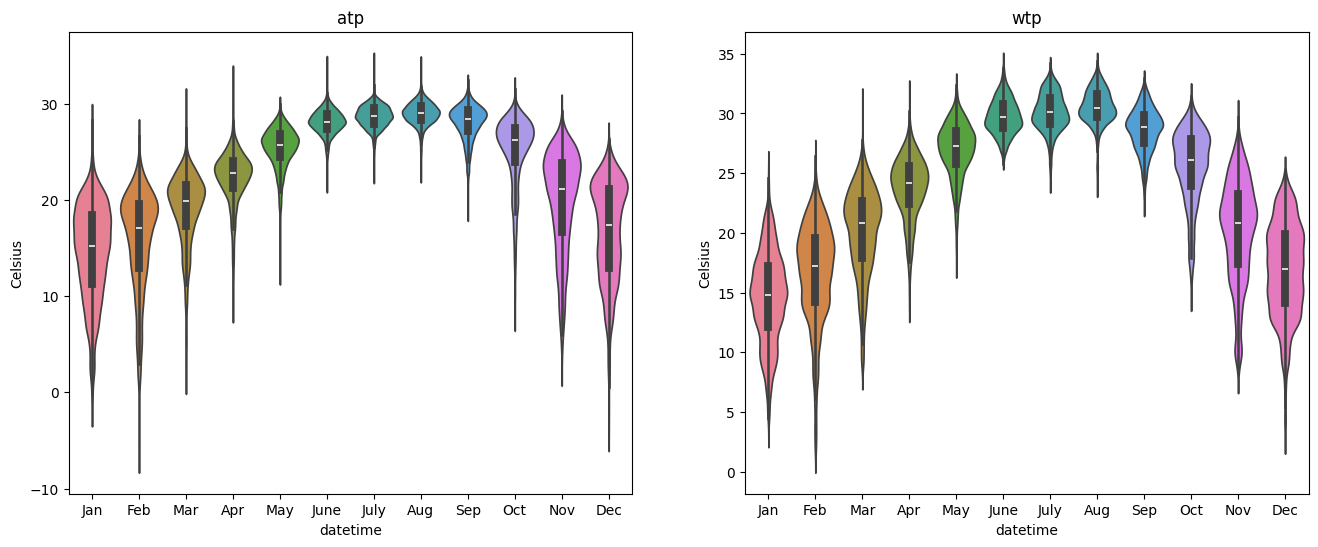

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))

sns.violinplot(data=df.set_index(df.index.month, append=True)['atp'].unstack(), ax=axs[0])
sns.violinplot(data=df.set_index(df.index.month, append=True)['wtp'].unstack(), ax=axs[1])

axs[0].set_ylabel("Celsius")
axs[1].set_ylabel("Celsius")

axs[0].set_title("atp")
axs[1].set_title("wtp")

months = ["Jan", "Feb", "Mar", "Apr", "May", "June", "July", "Aug", "Sep", "Oct", "Nov", "Dec"]
axs[0].set_xticklabels(months);
axs[1].set_xticklabels(months);

Text(0.5, 1.0, 'wtp')

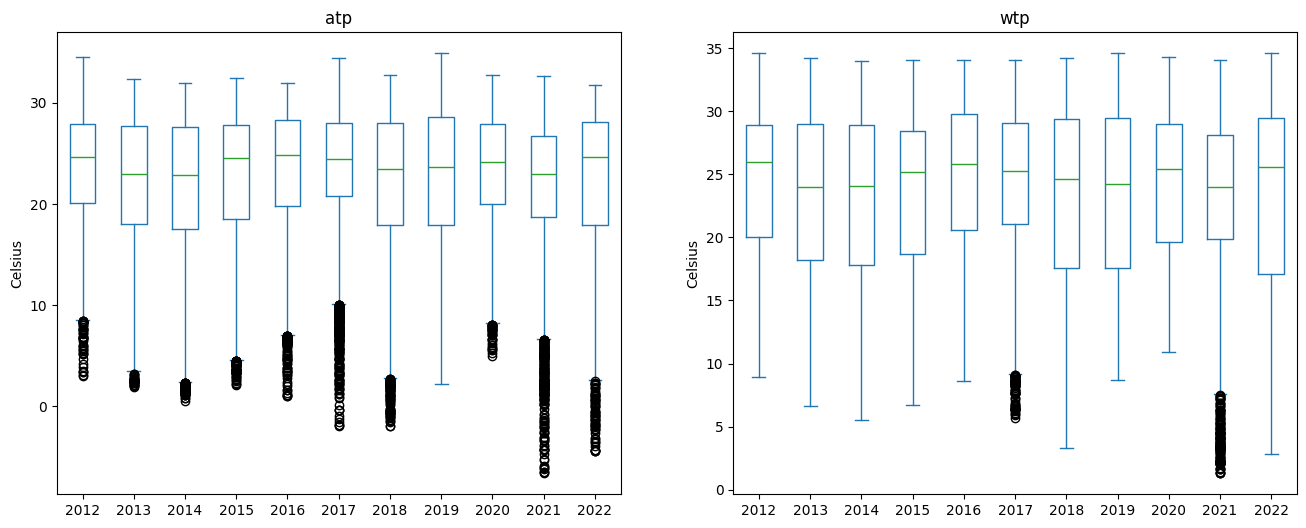

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))

df.set_index(df.index.year, append=True)['atp'].unstack().plot.box(ax=axs[0])
df.set_index(df.index.year, append=True)['wtp'].unstack().plot.box(ax=axs[1])

axs[0].set_ylabel("Celsius")
axs[1].set_ylabel("Celsius")

axs[0].set_title("atp")
axs[1].set_title("wtp")

Text(0.5, 1.0, 'wtp')

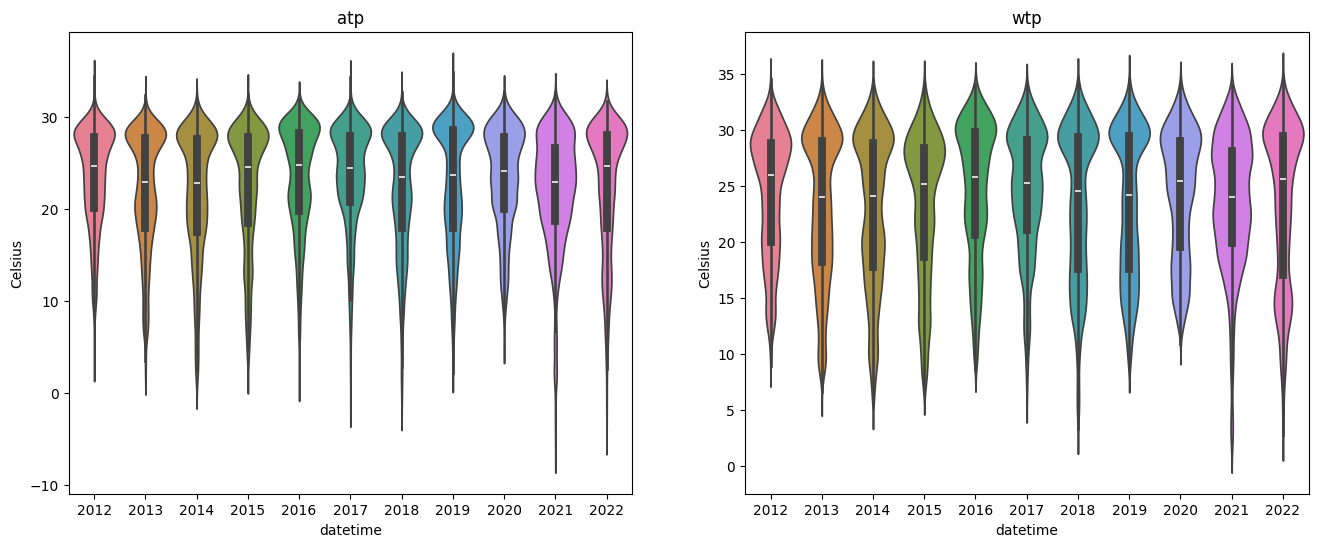

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(16,6))

sns.violinplot(data=df.set_index(df.index.year, append=True)['atp'].unstack(), ax=axs[0])
sns.violinplot(data=df.set_index(df.index.year, append=True)['wtp'].unstack(), ax=axs[1])

axs[0].set_ylabel("Celsius")
axs[1].set_ylabel("Celsius")

axs[0].set_title("atp")
axs[1].set_title("wtp")

# Histograms

<Axes: title={'center': 'wtp'}, ylabel='Frequency'>

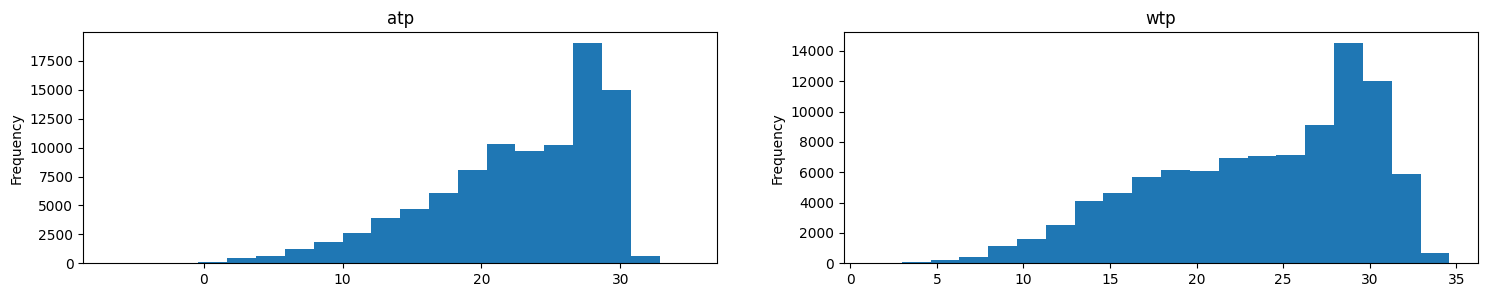

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 3))
df['atp'].plot(kind='hist', bins=20, title='atp', ax=axs[0])
df['wtp'].plot(kind='hist', bins=20, title='wtp', ax=axs[1])

## Missing Values

In [ ]:
n_samples = len(df)

dfCounts = pd.DataFrame({
    "samples" : df.count(),
    "missing" : df.isna().sum(),
    "missing_prop" : df.isna().sum() / df.count(),
    "total" : df.isna().sum() + df.count()
})

dfCounts

samples  missing  missing_prop  total
atp    94936     1496      0.015758  96432
wtp    96022      410      0.004270  96432

In [ ]:
dfnan = df.copy()
dfnan["atp"] = np.isnan(df["atp"].values).astype(int)
dfnan["wtp"] = np.isnan(df["wtp"].values).astype(int)

[]

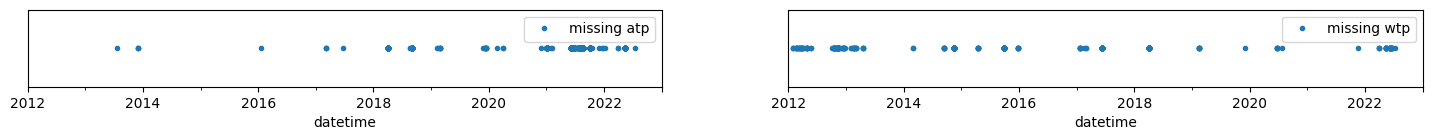

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 1))
dfnan.plot(y="atp", style=".", ax=axs[0], label="missing atp")
dfnan.plot(y="wtp", style=".", ax=axs[1], label="missing wtp")
axs[0].set_ylim(.9, 1.1)
axs[1].set_ylim(.9, 1.1)
axs[0].set_yticks([])
axs[1].set_yticks([])

# Cold-stunning probabilities

In [ ]:
# Cold-stunning threshold
wtp_cs_thresh = 8.0

**Probability of cold-stunning day**

Number of cold-stunning event (days): 52
Number of days: 4018
Probability of cold-stunning event: 52 / 4018 = 0.012941762070681932


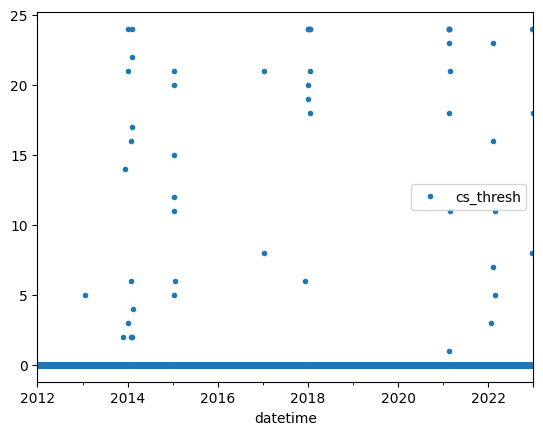

In [ ]:
df_cs = df.copy()

df_cs["cs_thresh"] = df["wtp"] <= wtp_cs_thresh

df_cse = df_cs.groupby(pd.Grouper(freq='1D')).sum()

df_cse.plot(y="cs_thresh", style=".")

n_total = len(df_cse)
n_csdays = np.sum(df_cse["cs_thresh"] > 0)
cs_prob = n_csdays / n_total

print("Number of cold-stunning event (days): {}".format(n_csdays))
print("Number of days: {}".format(n_total))
print("Probability of cold-stunning event: {} / {} = {}".format(n_csdays, n_total, cs_prob))

# Correlation

Text(0.5, 1.0, '')

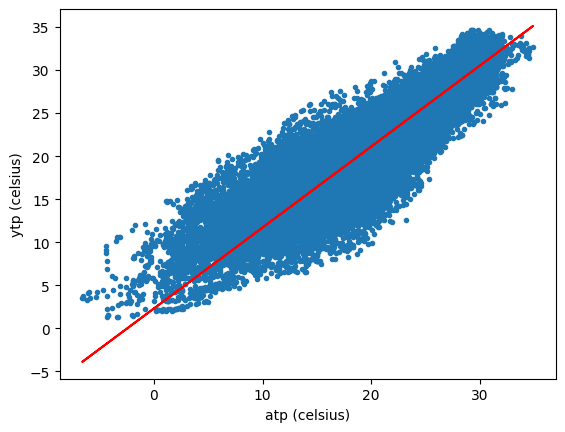

In [ ]:
# Drop missing values
dfc = df.dropna(axis = 0, how = 'any')

x = dfc["atp"]
y = dfc["wtp"]

# Scatter the points
plt.scatter(x, y, marker=".")
plt.xlabel("atp (celsius)")
plt.ylabel("ytp (celsius)")
# fitting a linear regression line
m, b = np.polyfit(x, y, 1)
# adding the regression line to the scatter plot
plt.plot(x, m*x + b, color="red")

plt.title("")

In [ ]:
dfCorr = pd.DataFrame({
    "spearman" : [x.corr(y, method='spearman')],
    "pearson"  : [x.corr(y, method='pearson')],
    "kendall"  : [x.corr(y, method='kendall')],
})
dfCorr

spearman   pearson  kendall
0  0.945311  0.935725    0.796

## Missing Value Imputation

The next plots require unbroken time series

In [ ]:
# Impute missing values with mean
dfi = df.fillna(df.mean())
dfi.index.freq = 'h'

decomp_atp = seasonal_decompose(dfi["atp"])
decomp_wtp = seasonal_decompose(dfi["wtp"])

## Decomposition of trend & seasonality

<Axes: xlabel='datetime'>

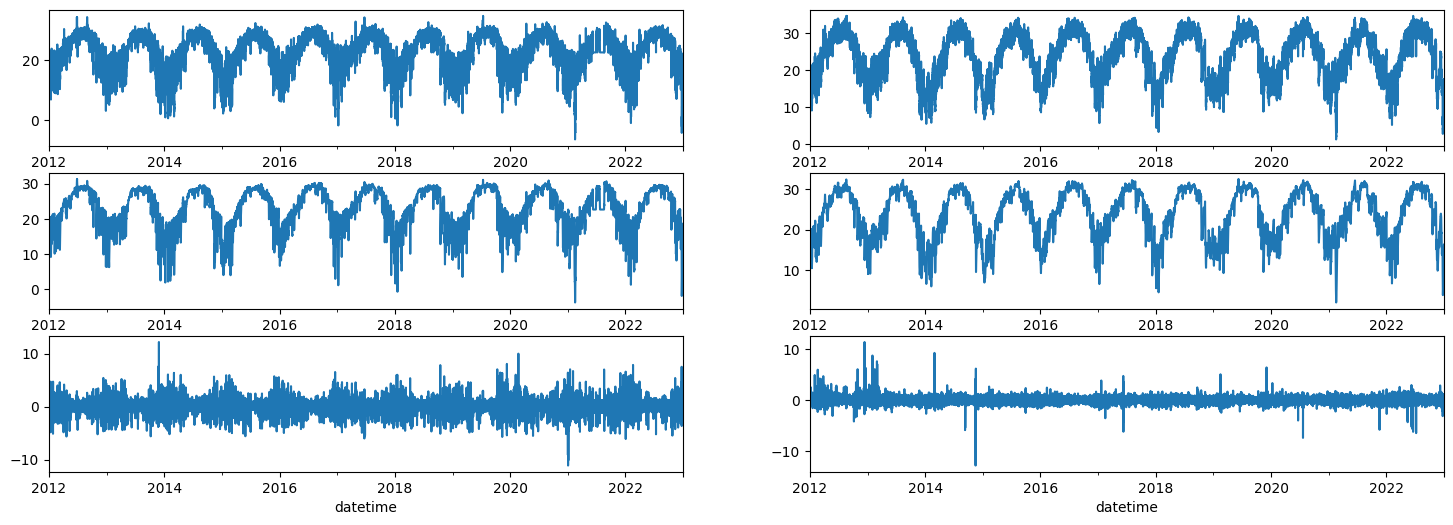

In [ ]:
fig, axs = plt.subplots(3, 2, figsize=(18, 6))

decomp_atp.observed.plot(ax=axs[0,0])
decomp_atp.trend.plot(ax=axs[1,0])
decomp_atp.resid.plot(ax=axs[2,0])

decomp_wtp.observed.plot(ax=axs[0,1])
decomp_wtp.trend.plot(ax=axs[1,1])
decomp_wtp.resid.plot(ax=axs[2,1])


## Autocorrelation

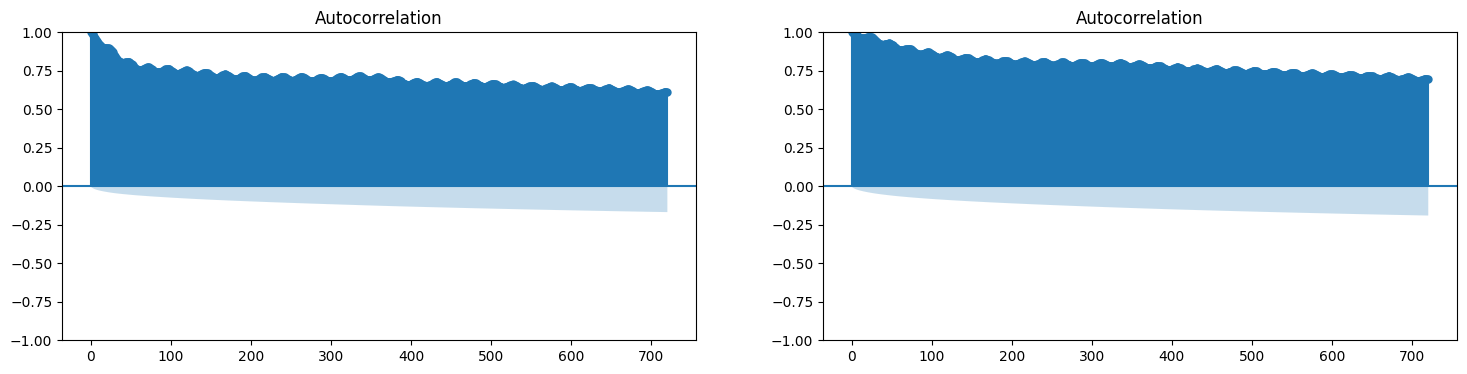

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18, 4))

fig = tsaplots.plot_acf(dfc['atp'], lags= 720, ax=axs[0])
fig = tsaplots.plot_acf(dfc['wtp'], lags= 720, ax=axs[1])

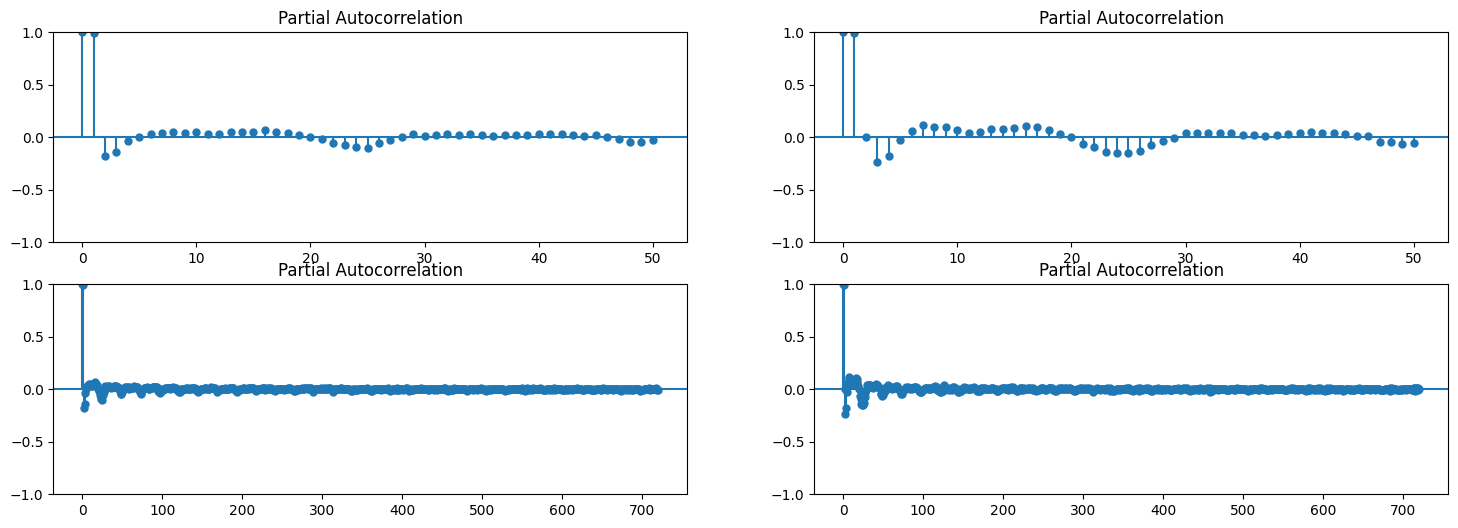

In [ ]:
fig, axs = plt.subplots(2, 2, figsize=(18, 6))

fig = tsaplots.plot_pacf(dfi['atp'], lags=50, ax=axs[0, 0])
fig = tsaplots.plot_pacf(dfi['atp'], lags=720, ax=axs[1, 0])
fig = tsaplots.plot_pacf(dfi['wtp'], lags=50, ax=axs[0, 1])
fig = tsaplots.plot_pacf(dfi['wtp'], lags=720, ax=axs[1, 1])

In [ ]:
def calc_lagged_corrs(x, y, n_lags):
  lags = range(1, n_lags)
  corrs = np.zeros((len(lags), 2))

  for i, lag in enumerate(lags):
    x_ = x[:-lag]
    y_ = y[lag:]

    corrs[i, 0] = np.corrcoef(x_, y_)[0,1]
    corrs[i, 1] = spearmanr(x_, y_)[0]

  dfCorr = pd.DataFrame({
      "pearson" : corrs[:, 0],
      "spearman"  : corrs[:, 1],
  })

  return dfCorr

Text(0.5, 1.0, 'WTP Autocorrelation (hourly lags)')

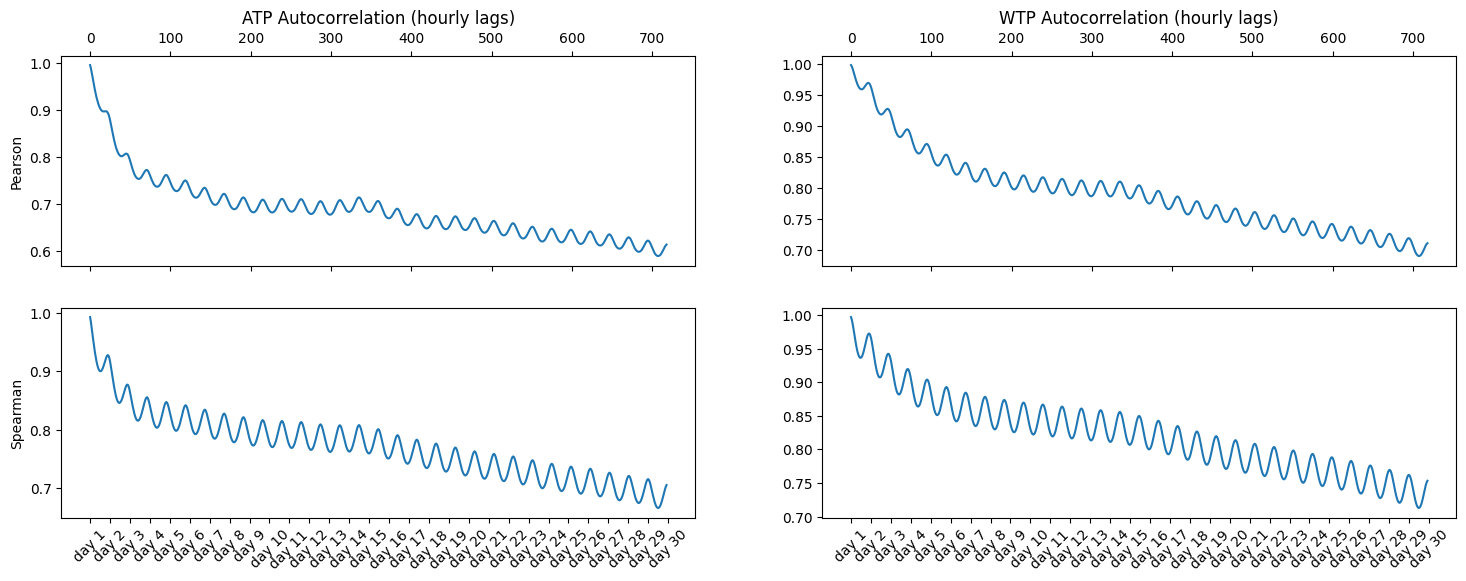

In [ ]:
n_lags = 720

df_corrs_atp = calc_lagged_corrs(dfi["atp"], dfi["atp"], n_lags)
df_corrs_wtp = calc_lagged_corrs(dfi["wtp"], dfi["wtp"], n_lags)

fig, axs = plt.subplots(2, 2, figsize=(18,6))

df_corrs_atp.plot(y="pearson", ax=axs[0, 0], legend=False)
df_corrs_atp.plot(y="spearman", ax=axs[1, 0], legend=False)

df_corrs_wtp.plot(y="pearson", ax=axs[0, 1], legend=False)
df_corrs_wtp.plot(y="spearman", ax=axs[1, 1], legend=False)

axs[0, 0].set_ylabel("Pearson")
axs[1, 0].set_ylabel("Spearman")

daily_ticks = np.linspace(0, n_lags, 30)
tick_labels = ["day " + str(i+1) for i in np.array(range(int(n_lags / 24)))]

axs[0, 0].tick_params(top=True, labeltop=True, bottom=True, labelbottom=False)
axs[1, 0].set_xticks( daily_ticks);
axs[1, 0].set_xticklabels( tick_labels);
axs[1, 0].tick_params(axis='x', labelrotation=45)
axs[0, 1].tick_params(top=True, labeltop=True, bottom=True, labelbottom=False)
axs[1, 1].set_xticks( daily_ticks);
axs[1, 1].set_xticklabels( tick_labels);
axs[1, 1].tick_params(axis='x', labelrotation=45)

axs[0, 0].set_title("ATP Autocorrelation (hourly lags)")
axs[0, 1].set_title("WTP Autocorrelation (hourly lags)")

## Lagged correlation between ATP & WTP

Text(0.5, 0.98, 'Correlation between ATP & WTP (hourly lags)')

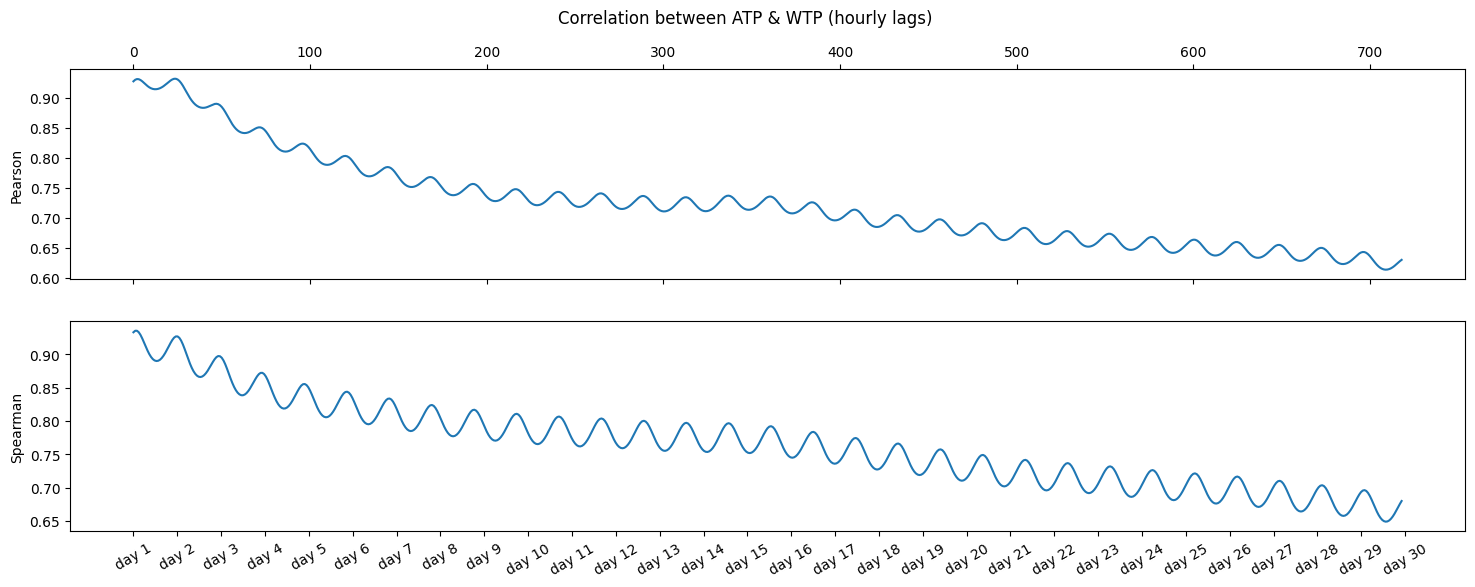

In [ ]:
dfCorr = calc_lagged_corrs(dfi["atp"], dfi["wtp"], n_lags)

fig, axs = plt.subplots(2, figsize=(18,6))

dfCorr.plot(y="pearson", ax=axs[0], legend=False)
dfCorr.plot(y="spearman", ax=axs[1], legend=False)

axs[0].set_ylabel("Pearson")
axs[1].set_ylabel("Spearman")

daily_ticks = np.linspace(0, n_lags, 30)
tick_labels = ["day " + str(i+1) for i in np.array(range(int(n_lags / 24)))]

axs[0].tick_params(top=True, labeltop=True, bottom=True, labelbottom=False)
axs[1].set_xticks( daily_ticks);
axs[1].set_xticklabels( tick_labels);
axs[1].tick_params(axis='x', labelrotation=30)

fig.suptitle('Correlation between ATP & WTP (hourly lags)')

# Modeling

## Options

In [ ]:
prev_pred_hours = 6

loss_func = 'mean_squared_error'
hidden_sizes = [64, 64, 64]
learning_rate = 0.001  # 0.02
batch_size = 64
epochs = 10

shuffle = True
verbose = True

## Partition dataset

In [ ]:
# Reserve last year for training
test_years = selected_years[-1]
years = selected_years[:-1]

# Setup cross-fold validation sets
n_sets = len(years)
partitions = [(np.array(list(set(years).difference(set([val_year])))),
                np.array([val_year])) for val_year in years]

partitions

[(array([2016, 2017, 2018, 2019, 2020, 2021, 2013, 2014, 2015]),
  array([2012])),
 (array([2016, 2017, 2018, 2019, 2020, 2021, 2012, 2014, 2015]),
  array([2013])),
 (array([2016, 2017, 2018, 2019, 2020, 2021, 2012, 2013, 2015]),
  array([2014])),
 (array([2016, 2017, 2018, 2019, 2020, 2021, 2012, 2013, 2014]),
  array([2015])),
 (array([2017, 2018, 2019, 2020, 2021, 2012, 2013, 2014, 2015]),
  array([2016])),
 (array([2016, 2018, 2019, 2020, 2021, 2012, 2013, 2014, 2015]),
  array([2017])),
 (array([2016, 2017, 2019, 2020, 2021, 2012, 2013, 2014, 2015]),
  array([2018])),
 (array([2016, 2017, 2018, 2020, 2021, 2012, 2013, 2014, 2015]),
  array([2019])),
 (array([2016, 2017, 2018, 2019, 2021, 2012, 2013, 2014, 2015]),
  array([2020])),
 (array([2016, 2017, 2018, 2019, 2020, 2012, 2013, 2014, 2015]),
  array([2021]))]

## Preprocess

In [ ]:
def split_preds_targets(df, lead_time_hours, target_var="wtp", prev_pred_hours=3):

  data = df.to_numpy()
  n_samples = len(data)

  # Adjust lead time hours to start from end of predictor time series
  lead_time_hours = lead_time_hours + prev_pred_hours

  start_idxs = np.array(range(0, n_samples - prev_pred_hours)).astype(int)
  stop_idxs = start_idxs + prev_pred_hours
  n_train = len(start_idxs)

  x = np.zeros((n_train, data.shape[1] * prev_pred_hours))
  for i in range(n_train):
    x[i] = data[start_idxs[i]:stop_idxs[i]].flatten()
  x = x[:-lead_time_hours]

  y = df[target_var][lead_time_hours:].to_numpy()
  y = y[:-prev_pred_hours]

  feature_names = []
  for i in range(prev_pred_hours):
    for colname in df.columns:
      feature_names.append(colname + "-" + str(prev_pred_hours - i - 1))

  return x, y, feature_names

In [ ]:
# All test data
df_test = dfi[dfi.index.year.isin([test_years])]
# Convert to numpy preds & targets
x_test, y_test, feature_names = split_preds_targets(df_test, lead_time_hours, prev_pred_hours=prev_pred_hours)
# Input shape
input_shape = x_test.shape[1]

## Normalization

In [ ]:
# All training and validationd data
df_all = dfi[dfi.index.year.isin(years)]
# Convert to numpy preds & targets
x_all, y_all, feature_names = split_preds_targets(df_all, lead_time_hours, prev_pred_hours=prev_pred_hours)

# Build normalization layer
normalizer = keras.layers.Normalization(axis=-1)
normalizer.adapt(x_all)

## Model Architecture

In [ ]:
def build_model(norm, hidden_sizes=[64, 64]):

  model = keras.Sequential(
      [norm] + \
      [keras.layers.Dense(hs, activation='relu') \
                  for hs in hidden_sizes] + \
      [keras.layers.Dense(1)]
  )
  return model

## Train Models

In [ ]:
# Number of training runs
n_partitions = len(partitions)

# Init models and compile models
history = [None for p in partitions]
models = [build_model(normalizer) for p in partitions]
for model in models:
  model.compile(loss=loss_func,
              optimizer=tf.keras.optimizers.Adam(learning_rate),
              metrics=[keras.metrics.mean_absolute_error])

# Summary of first model
models[0].summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ normalization (Normalization)        │ (87648, 12)                 │              25 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 25 (104.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 25 (104.00 B)

In [ ]:
for i, partition in enumerate(partitions):

  print("Cross-Validation Fold {}".format(i))

  train_years = partition[0]
  valid_years = partition[1]

  df_train = dfi[dfi.index.year.isin(train_years)]
  df_valid = dfi[dfi.index.year.isin(valid_years)]

  x_train, y_train, feature_names = split_preds_targets(df_train, lead_time_hours, prev_pred_hours=prev_pred_hours)
  x_valid, y_valid, _ = split_preds_targets(df_valid, lead_time_hours, prev_pred_hours=prev_pred_hours)

  print("  Training:    x: {}, \t  y: {}".format(x_train.shape, y_train.shape))
  print("  Validation:  x: {}, \t  y: {}".format(x_valid.shape, y_valid.shape))


  history[i] = models[i].fit(
      x_train, y_train,
      validation_data=(x_valid, y_valid),
      batch_size=batch_size,
      epochs=epochs,
      shuffle=shuffle,
      verbose=verbose)

  print("")

Cross-Validation Fold 0
  Training:    x: (78864, 12), 	  y: (78864,)
  Validation:  x: (8760, 12), 	  y: (8760,)
Epoch 1/10
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 123.1406 - mean_absolute_error: 7.2468 - val_loss: 2.5149 - val_mean_absolute_error: 1.2126
Epoch 2/10
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 2.0019 - mean_absolute_error: 1.0859 - val_loss: 2.5219 - val_mean_absolute_error: 1.1868
Epoch 3/10
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 1.8505 - mean_absolute_error: 1.0331 - val_loss: 2.3817 - val_mean_absolute_error: 1.1464
Epoch 4/10
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - loss: 1.8239 - mean_absolute_error: 1.0171 - val_loss: 2.4306 - val_mean_absolute_error: 1.1839
Epoch 5/10
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 1.8374 - mean_absolute_error: 1.0224 - val_loss: 2.4229 - val_mean_absolute_error: 1.1544
Epoch 6/10
1233/1233 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - loss: 1.7790 - mean_absolute_error: 1.0035 - val_loss: 2.4659 - val_

## Evaluate

**Convergence curves**

Text(0, 0.5, 'Loss')

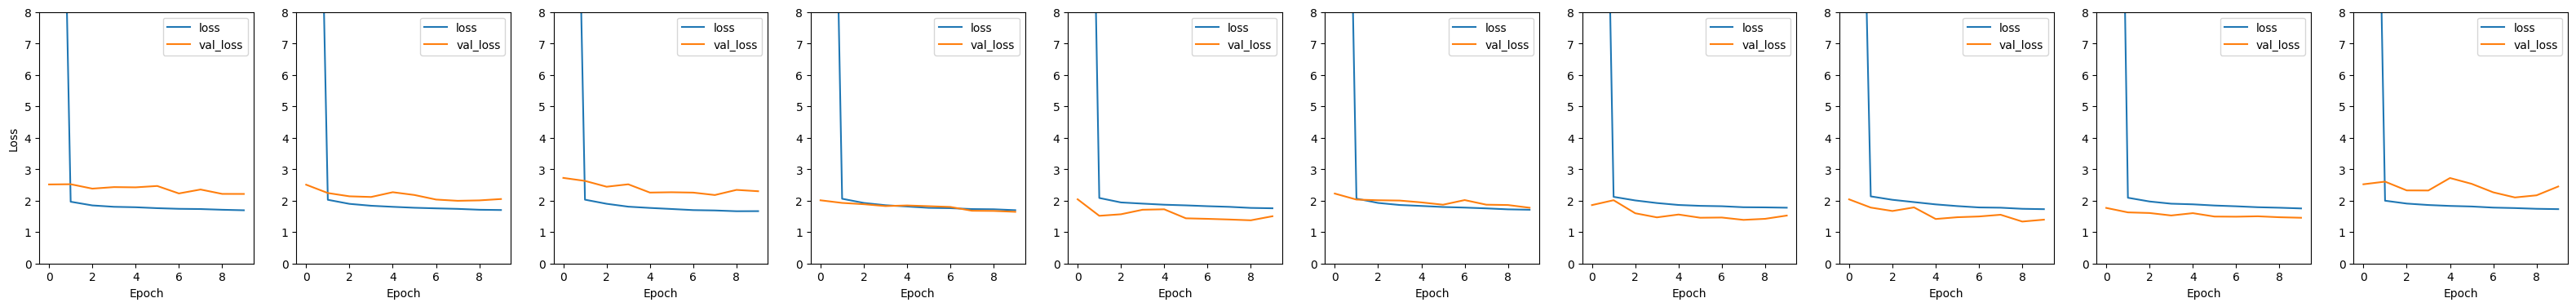

In [ ]:
fig, axs = plt.subplots(1, n_partitions, figsize=(n_partitions*4, 4))
for i, hist in enumerate(history):
  axs[i].plot(hist.history['loss'], label='loss')
  axs[i].plot(hist.history['val_loss'], label='val_loss')
  axs[i].set_xlabel('Epoch')
  axs[i].set_ylim(0, 8)
  axs[i].legend()
axs[0].set_ylabel('Loss')

**Prediction times series**

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


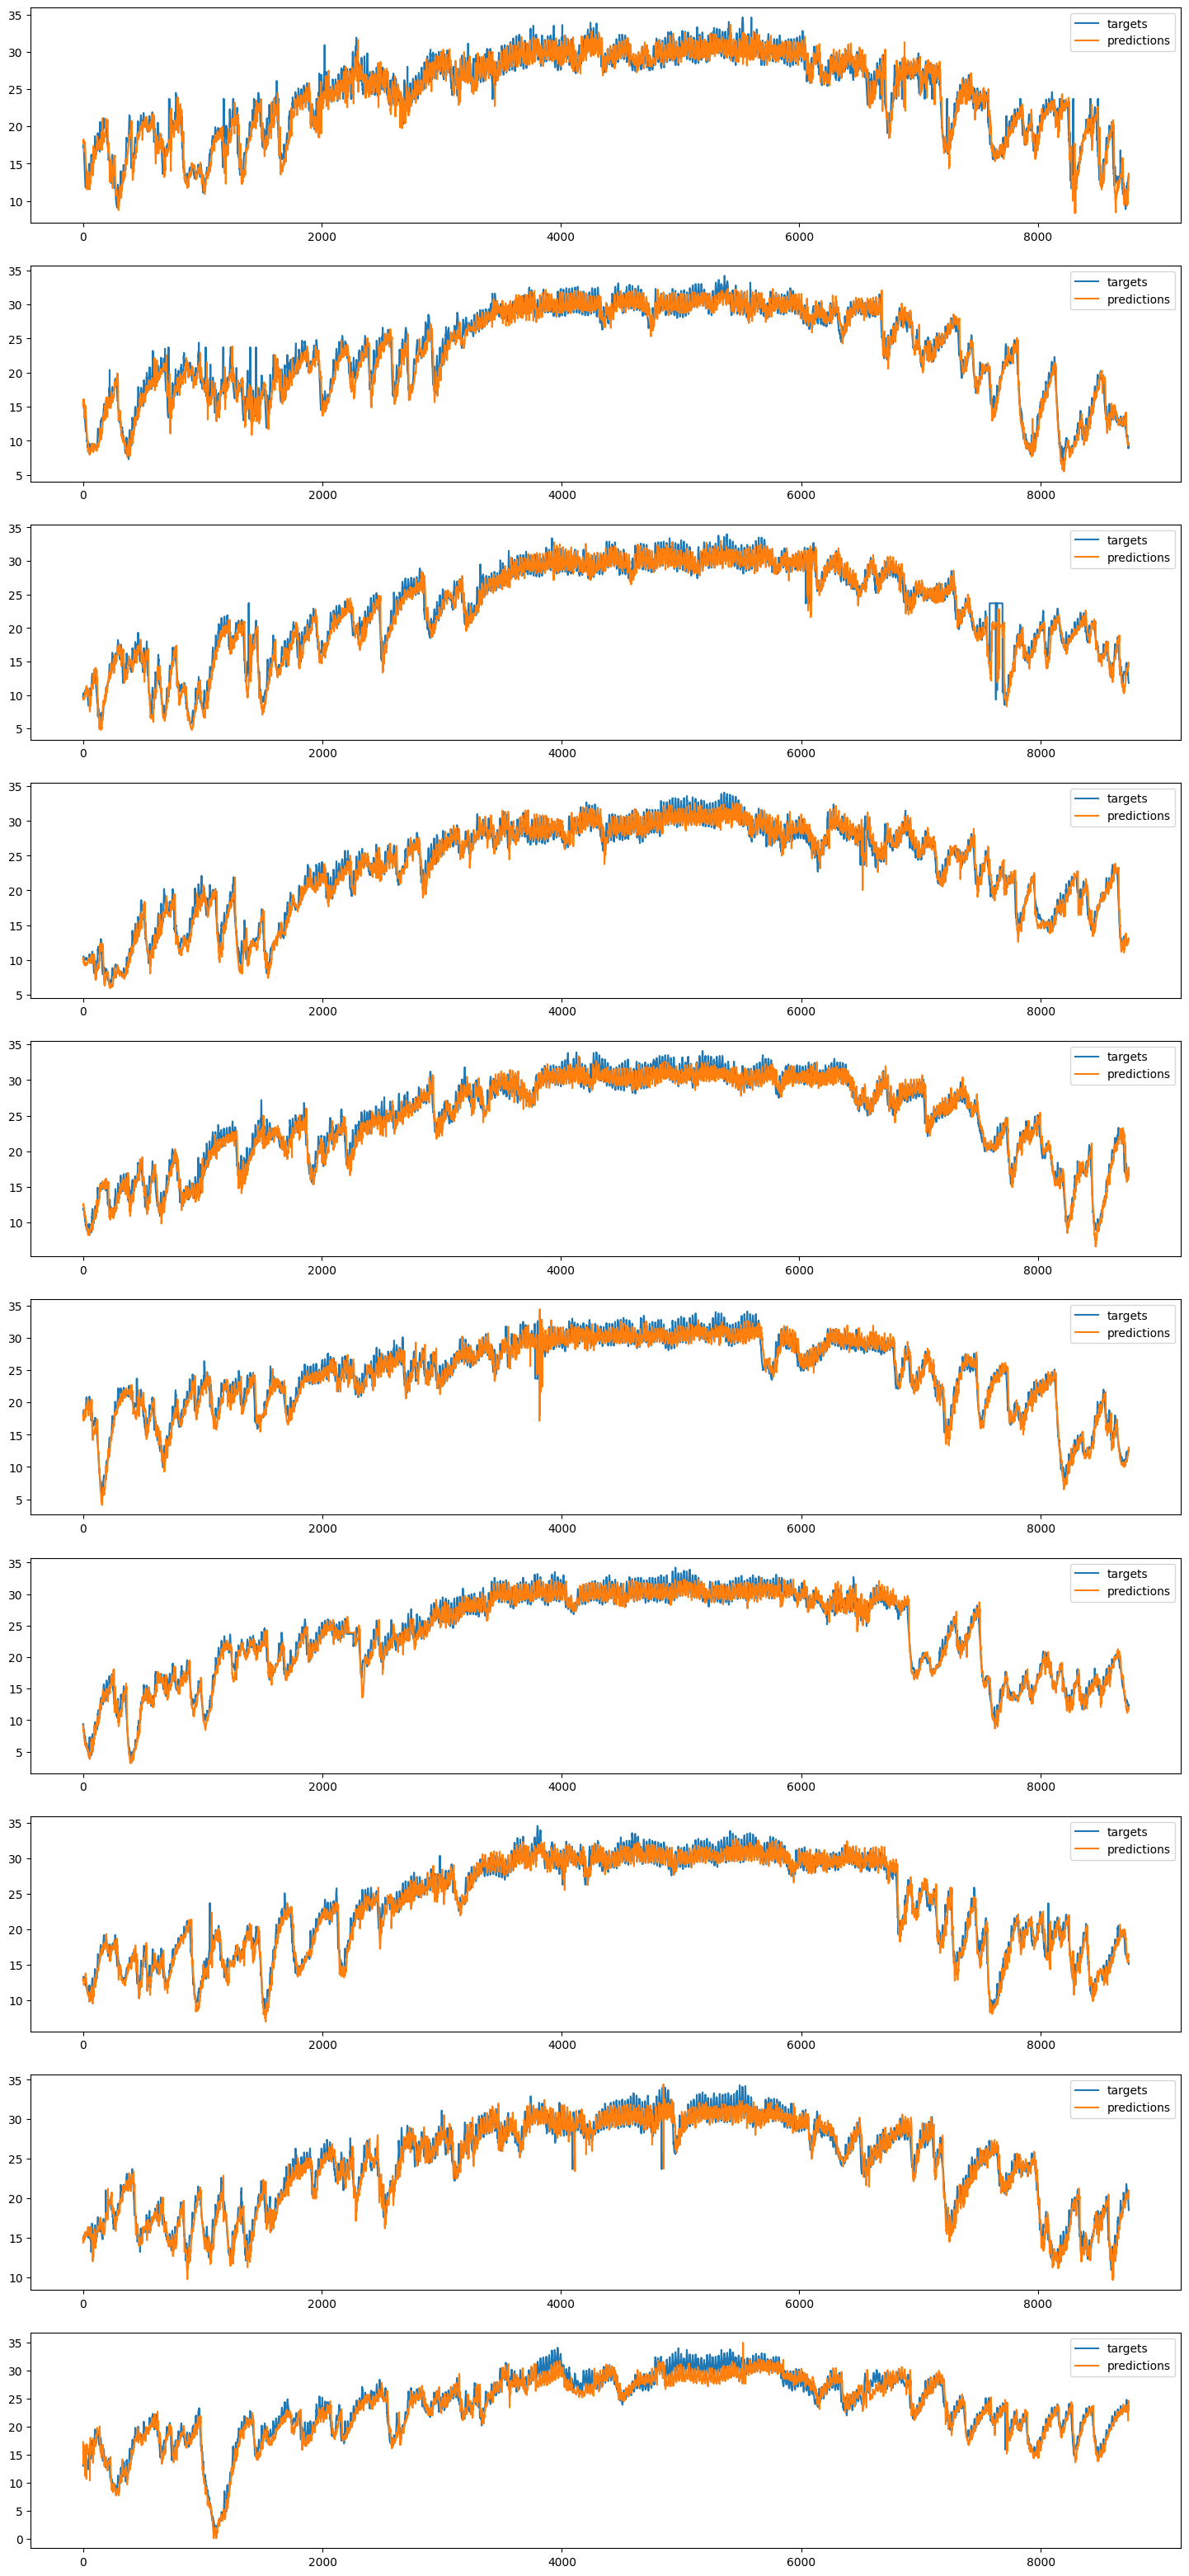

In [ ]:
fig, axs = plt.subplots(n_partitions, figsize=(18, 4 * n_partitions))

for i in range(n_partitions):
  valid_years = partitions[i][1]
  df_valid = dfi[dfi.index.year.isin(valid_years)]
  x_valid, y_valid, _ = split_preds_targets(df_valid, lead_time_hours, prev_pred_hours=prev_pred_hours)

  y_ = model.predict(x_valid).flatten()

  axs[i].plot(y_valid, label="targets")
  axs[i].plot(y_, label="predictions")
  axs[i].legend()

**Evaluation metrics**

In [ ]:
metrics = {
    "mean_squared_error"  : mean_squared_error,
    "mean_absolute_error" : mean_absolute_error,
    "r2_score"            : r2_score,
}

keys = metrics.keys()
n_metrics = len(keys)

In [ ]:
results = np.zeros((n_partitions, n_metrics))

for i in range(n_partitions):
  valid_years = partitions[i][1]
  df_valid = dfi[dfi.index.year.isin(valid_years)]
  x_valid, y_valid, _ = split_preds_targets(df_valid, lead_time_hours, prev_pred_hours=prev_pred_hours)

  y_ = model.predict(x_valid).flatten()

  for j, key in enumerate(keys):
    results[i, j] = metrics[key](y_valid, y_)

  #results[i, :] = model.evaluate(x_valid, y_valid, verbose=0)

dfMetrics = pd.DataFrame(results, columns=keys)
dfMetrics

274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
274/274 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


mean_squared_error  mean_absolute_error  r2_score
0            2.232486             1.124490  0.927020
1            2.065803             1.090061  0.951145
2            2.348745             1.096612  0.947589
3            1.831339             1.035326  0.955933
4            1.434068             0.921013  0.960482
5            1.876425             1.032940  0.939579
6            1.464585             0.927805  0.968090
7            1.455260             0.905079  0.965660
8            1.539796             0.951112  0.950224
9            2.449288             1.211101  0.928417

<Axes: >

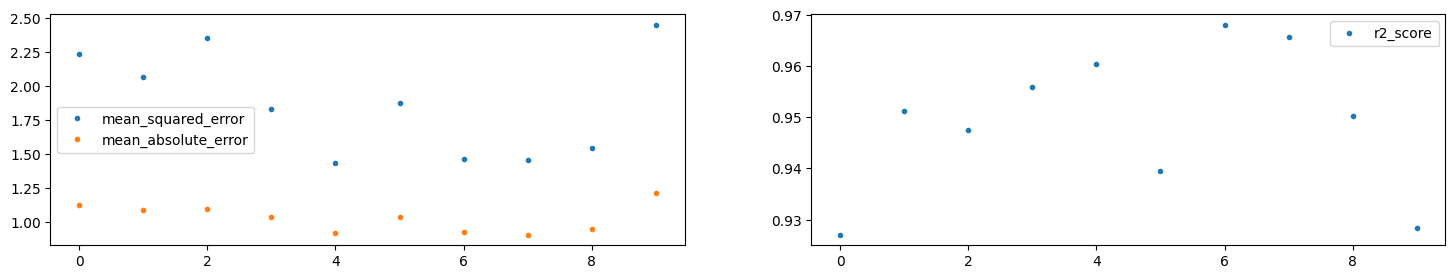

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(18,3))
dfMetrics.plot(y="mean_squared_error", style=".", ax=axs[0])
dfMetrics.plot(y="mean_absolute_error", style=".", ax=axs[0])
dfMetrics.plot(y="r2_score", style=".", ax=axs[1])


## Test Evaluation

In [ ]:
# Get test data
df_test = dfi[dfi.index.year.isin([test_years])]
x_test, y_test, feature_names = split_preds_targets(df_test, lead_time_hours, prev_pred_hours=prev_pred_hours)

In [ ]:
# Get best model
best_idx = np.argmax(dfMetrics["r2_score"].values)
best_model = models[best_idx]

# Get predictions
preds_test = best_model.predict(x_test).flatten()

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


In [ ]:
best_model.save('laguna_madre_watertemp.keras')

**Time series comparison**

Text(0.5, 1.0, 'Test data evaluation')

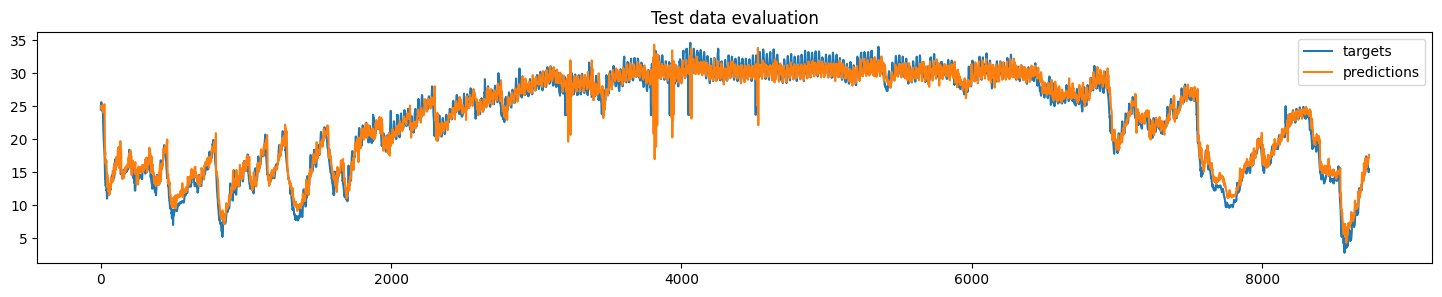

In [ ]:
fig, ax = plt.subplots(figsize=(18, 3))
ax.plot(y_test, label="targets")
ax.plot(preds_test, label="predictions")
ax.legend()
ax.set_title("Test data evaluation")

**Metrics**

In [ ]:
for j, key in enumerate(keys):
  print("{}:  {}".format(key, metrics[key](y_test, preds_test)))

mean_squared_error:  2.0565850471272547
mean_absolute_error:  1.0430716130241109
r2_score:  0.9595742697754726


**Error Distribution**

Text(0.5, 1.0, 'Errors (targets - predictions)')

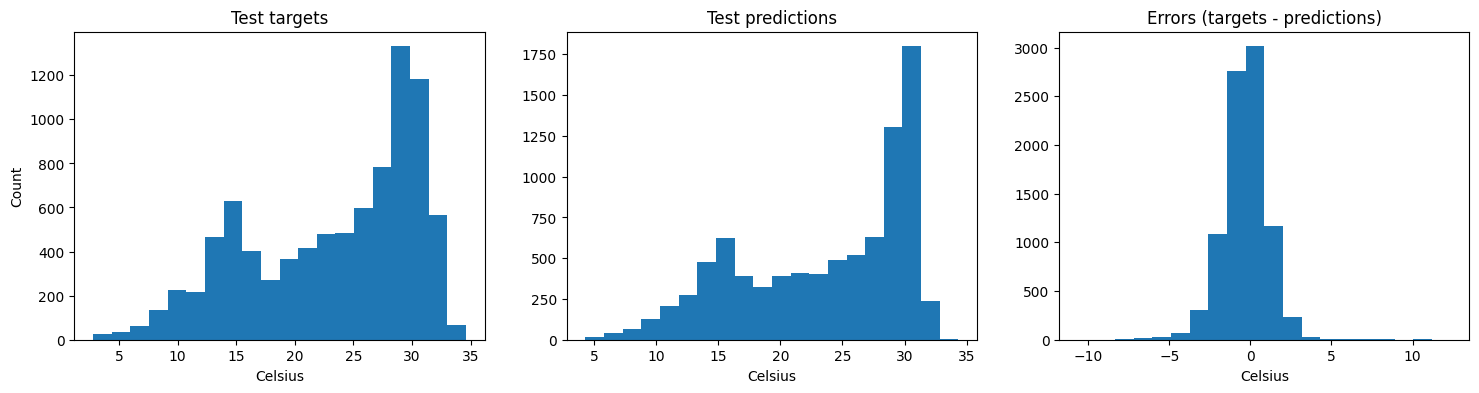

In [ ]:
y_error = y_test - preds_test

fig, axs = plt.subplots(1, 3, figsize=(18, 4))

axs[0].hist(y_test, bins=20)
axs[0].set_ylabel("Count")
axs[0].set_title("Test targets")
axs[0].set_xlabel("Celsius")

axs[1].hist(preds_test, bins=20)
axs[1].set_title("Test predictions")
axs[1].set_xlabel("Celsius")

axs[2].hist(y_error, bins=20);
axs[2].set_xlabel("Celsius")
axs[2].set_title("Errors (targets - predictions)")

# Explainable AI

**Setup**

In [ ]:
!pip install rfpimp
!pip install scikeras
from rfpimp import *
from scikeras.wrappers import KerasRegressor

  Preparing metadata (setup.py) ... done
  Created wheel for rfpimp: filename=rfpimp-1.3.7-py3-none-any.whl size=10649 sha256=6b1a5c81770824ebba74a908c901c166bc46ebcc1d0bcf31b851f4b20971c62e
  Stored in directory: /root/.cache/pip/wheels/8a/47/c9/053e734c43f85fa336b795eca6fef84c824595d5d21cdb96d5
Successfully built rfpimp


## Permutation Feature Importance

In [ ]:
eval_js('google.colab.output.setIframeHeight("100")')
r = permutation_importance(best_model, x_test, y_test, n_repeats=30, scoring='r2')

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
273/273 ━━━━━━━━

In [ ]:
for i in r.importances_mean.argsort()[::-1]:
  if r.importances_mean[i] - 2 * r.importances_std[i] > 0:
    print(f"{feature_names[i]:<8}"
    f"{r.importances_mean[i]:.3f}"
    f" +/- {r.importances_std[i]:.3f}")

wtp-5   0.981 +/- 0.008
wtp-0   0.804 +/- 0.006
atp-0   0.209 +/- 0.002
wtp-3   0.147 +/- 0.002
wtp-2   0.124 +/- 0.002
atp-5   0.078 +/- 0.001
wtp-4   0.068 +/- 0.001
wtp-1   0.039 +/- 0.001
atp-1   0.037 +/- 0.001
atp-2   0.031 +/- 0.001
atp-3   0.029 +/- 0.001
atp-4   0.026 +/- 0.001


### Grouped Permutation Feature Importance

In [ ]:
df_x = pd.DataFrame(x_test, columns=feature_names)
df_y = pd.DataFrame(y_test, columns=["target"])

In [ ]:
# Wrap model in scklearn wrapper
sk_model = KerasRegressor(model=best_model)
sk_model.fit(x_test, y_test)

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 1.9656 - mean_absolute_error: 1.0314


AttributeError: 'super' object has no attribute '__sklearn_tags__'

AttributeError: 'super' object has no attribute '__sklearn_tags__'

KerasRegressor(
	model=<Sequential name=sequential_6, built=True>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=rmsprop
	loss=None
	metrics=None
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
)

**No groups**

Just to confirm the above with different library

In [ ]:
def r2_ (model, x, y, temp):
    return r2_score(y, model.predict(x).flatten())

def mae_(model, x, y, temp):
    return -1 * mean_absolute_error(y, model.predict(x).flatten())

def mse_(model, x, y, temp):
    return -1 * mean_squared_error(y, model.predict(x).flatten())

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
273/273 ━━━━━━━━

Text(0.5, 29.000000000000007, 'mean_squared_error')

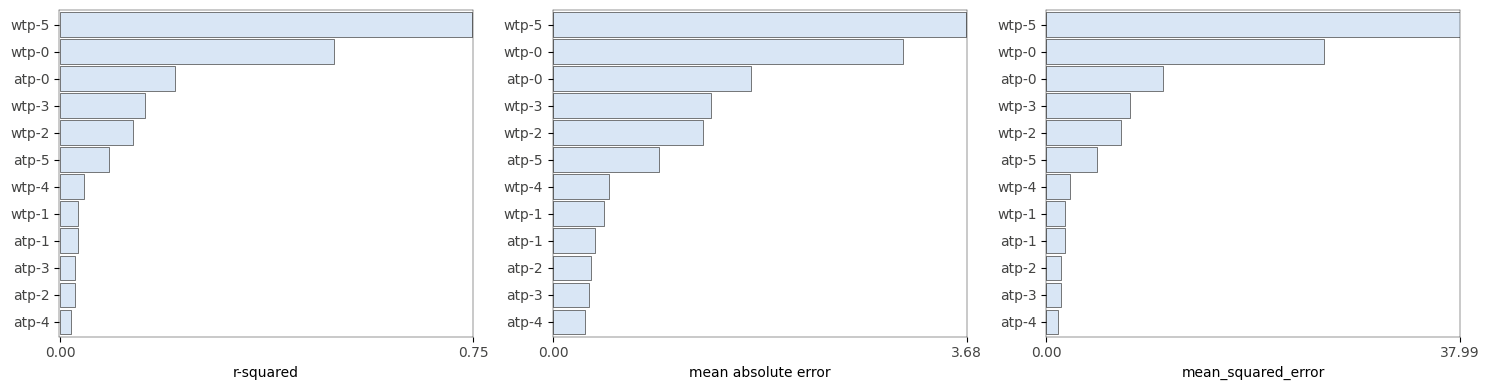

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
# R2
I = importances(sk_model, df_x, df_y, n_samples=-1, metric=r2_)
plot_importances(I, ax=axs[0])
axs[0].set_xlabel("r-squared")
# MAE
I = importances(sk_model, df_x, df_y, n_samples=-1, metric=mae_)
plot_importances(I, ax=axs[1])
axs[1].set_xlabel("mean absolute error")
# MAE
I = importances(sk_model, df_x, df_y, n_samples=-1, metric=mse_)
plot_importances(I, ax=axs[2])
axs[2].set_xlabel("mean_squared_error")

**Variable Groups**

Group all `wtp` and `atp` features

In [ ]:
variables = [fname.split("-")[0] for fname in feature_names]
feature_groups = [list(filter(lambda x: group in x, feature_names)) for group in np.unique(variables)]
feature_groups

[['atp-5', 'atp-4', 'atp-3', 'atp-2', 'atp-1', 'atp-0'],
 ['wtp-5', 'wtp-4', 'wtp-3', 'wtp-2', 'wtp-1', 'wtp-0']]

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Text(0.5, 29.000000000000007, 'mean_squared_error')

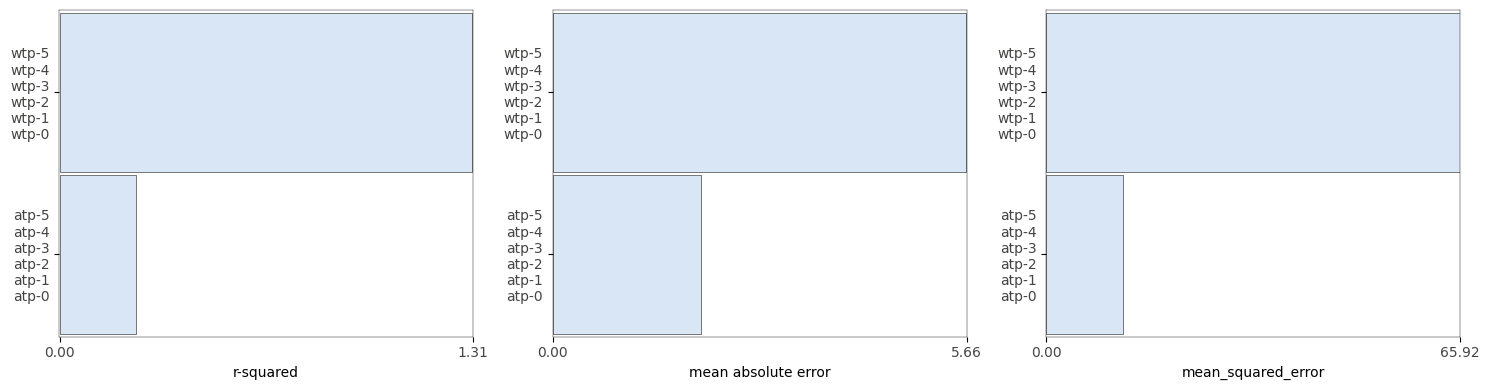

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
# R2
I = importances(sk_model, df_x, df_y, n_samples=-1, metric=r2_, features=feature_groups)
plot_importances(I, ax=axs[0])
axs[0].set_xlabel("r-squared")
# MAE
I = importances(sk_model, df_x, df_y, n_samples=-1, metric=mae_, features=feature_groups)
plot_importances(I, ax=axs[1])
axs[1].set_xlabel("mean absolute error")
# MAE
I = importances(sk_model, df_x, df_y, n_samples=-1, metric=mse_, features=feature_groups)
plot_importances(I, ax=axs[2])
axs[2].set_xlabel("mean_squared_error")

**Time Groups**

Group all features with same time (e.g. T-0, T-1, ...)

In [ ]:
variables = [fname.split("-")[1] for fname in feature_names]
feature_groups = [list(filter(lambda x: group in x, feature_names)) for group in np.unique(variables)]
feature_groups

[['atp-0', 'wtp-0'],
 ['atp-1', 'wtp-1'],
 ['atp-2', 'wtp-2'],
 ['atp-3', 'wtp-3'],
 ['atp-4', 'wtp-4'],
 ['atp-5', 'wtp-5']]

273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
273/273 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


Text(0.5, 29.000000000000007, 'mean_squared_error')

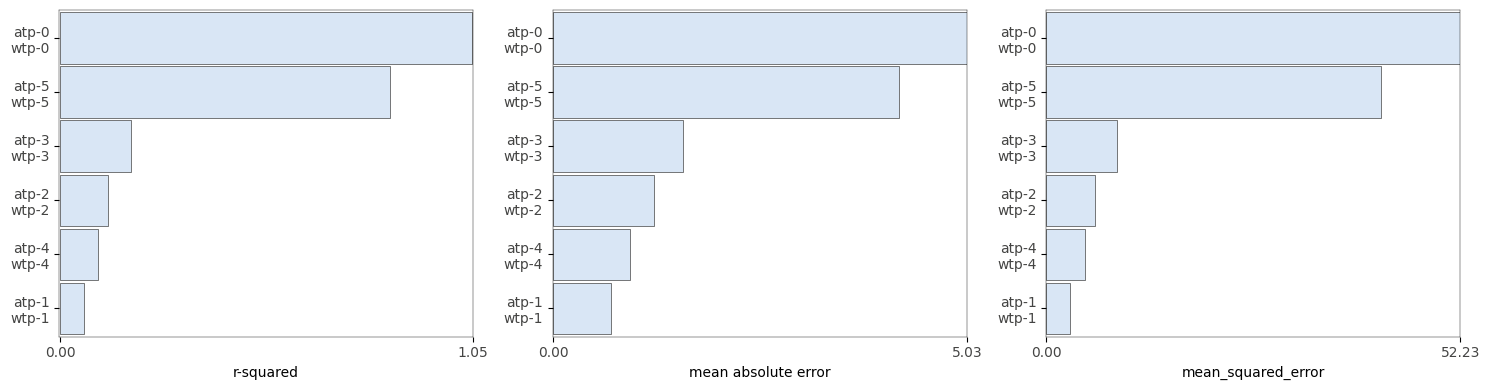

In [ ]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))
# R2
I = importances(sk_model, df_x, df_y, n_samples=-1, metric=r2_, features=feature_groups)
plot_importances(I, ax=axs[0])
axs[0].set_xlabel("r-squared")
# MAE
I = importances(sk_model, df_x, df_y, n_samples=-1, metric=mae_, features=feature_groups)
plot_importances(I, ax=axs[1])
axs[1].set_xlabel("mean absolute error")
# MAE
I = importances(sk_model, df_x, df_y, n_samples=-1, metric=mse_, features=feature_groups)
plot_importances(I, ax=axs[2])
axs[2].set_xlabel("mean_squared_error")

## SHAP

In [ ]:
!pip install shap
import shap

In [ ]:
X100 = shap.utils.sample(x_test, 100)

explainer = shap.Explainer(best_model, X100)
explanation = explainer(x_test)
explanation.feature_names = feature_names

PermutationExplainer explainer: 8737it [27:04,  5.38it/s]


**Global explanation**

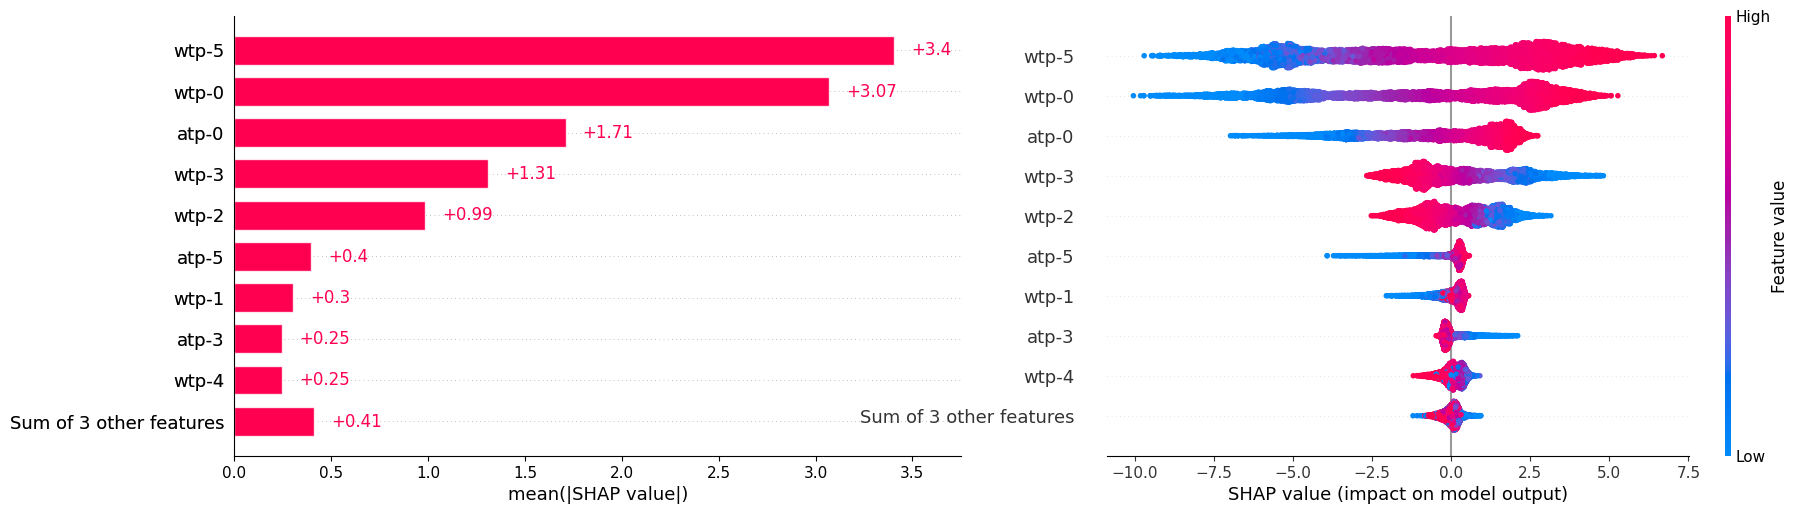

In [ ]:
plt.figure()
plt.subplot(1,2,1)
shap.plots.bar(explanation, show=False)
plt.subplot(1,2,2)
shap.plots.beeswarm(explanation, show=False)

# Optional for adjusting the margins:
plt.subplots_adjust(
    left=1,
    bottom=0.1,
    right=3,
    top=0.9)

**Local explanations**

In [ ]:
n_plots = 5

In [ ]:
preds_test = best_model.predict(x_test).flatten()
n_preds = len(preds_test)
y_diff = y_test - preds_test
sorted_idxs = np.argsort(np.abs(y_diff))

273/273 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


In [ ]:
best_idxs = sorted_idxs[:n_plots]
worst_idxs = sorted_idxs[-n_plots:]

middle = int(n_preds / 2)
middle_segment = (middle - int(n_plots / 2), middle + int(n_plots / 2 + (n_plots % 2)))
middle_idxs = sorted_idxs[middle_segment[0]:middle_segment[1]]

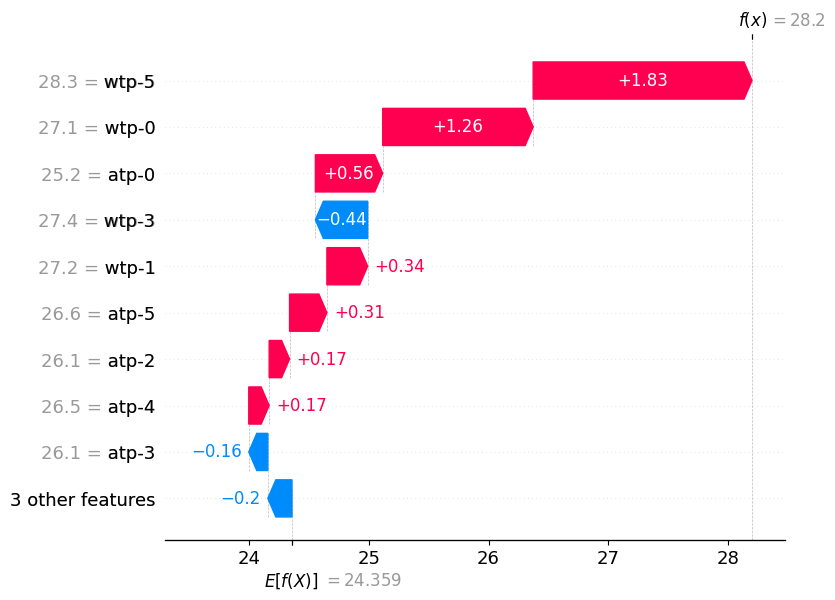

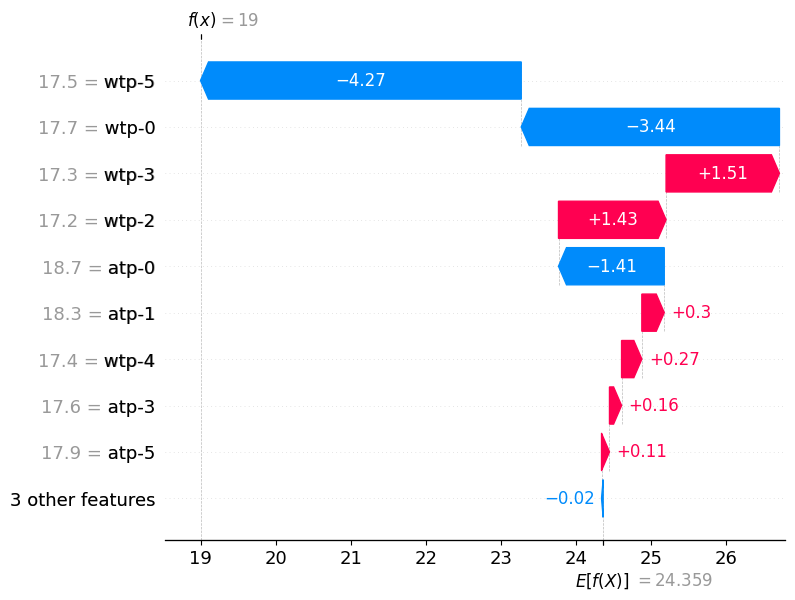

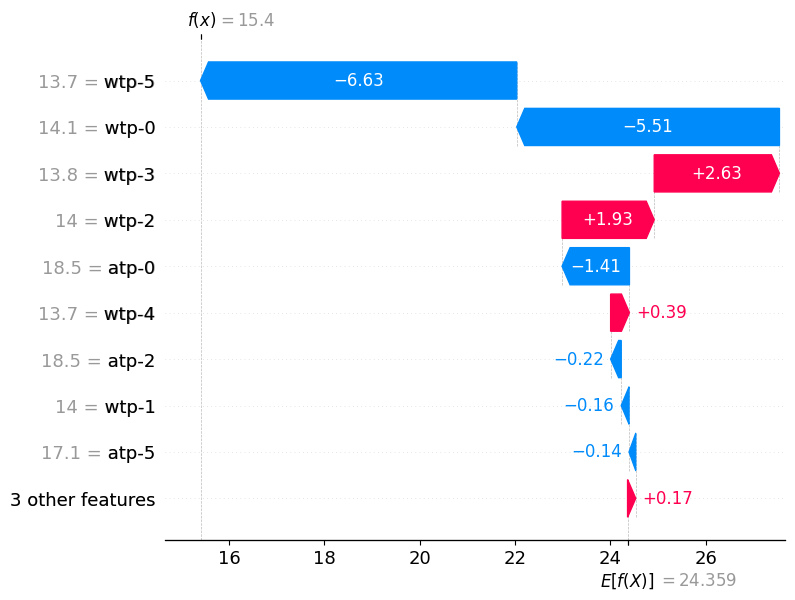

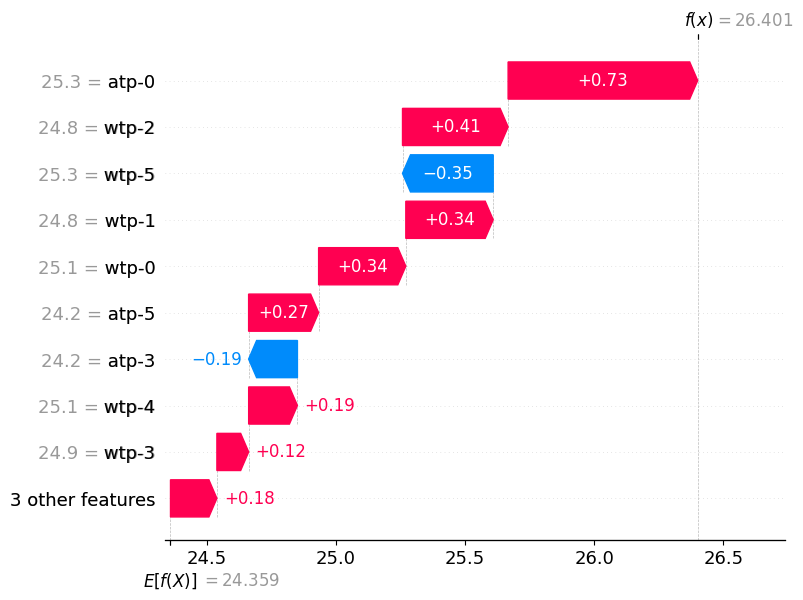

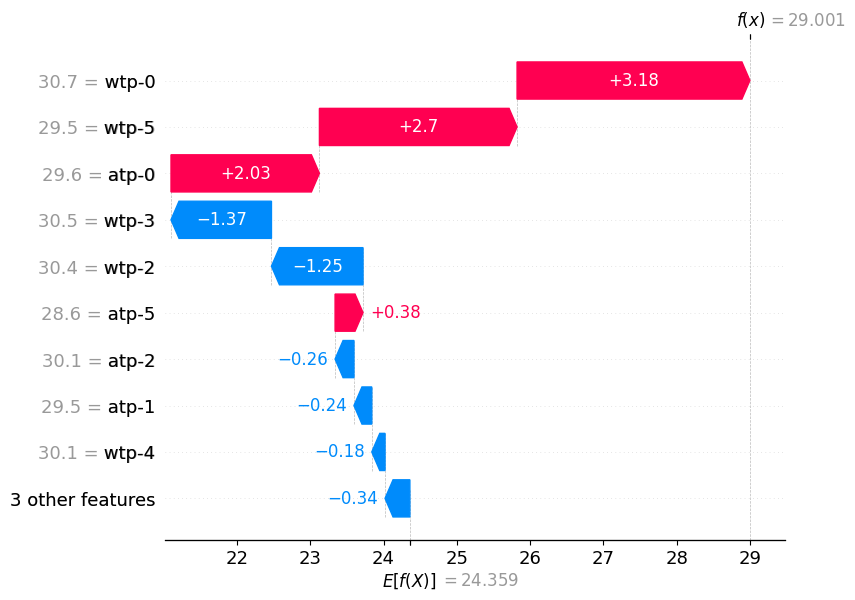

In [ ]:
# Explain best
for i in range(n_plots):
  shap.plots.waterfall(explanation[best_idxs[i]])

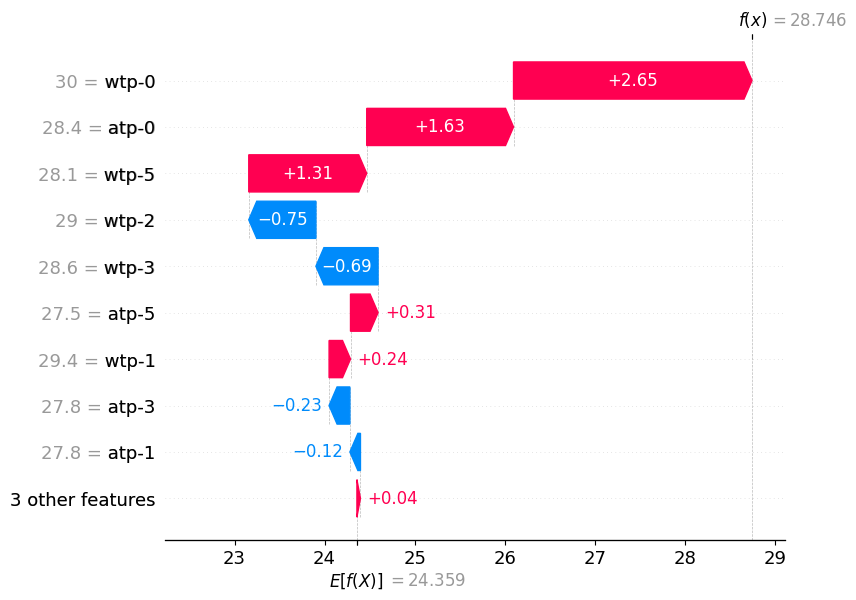

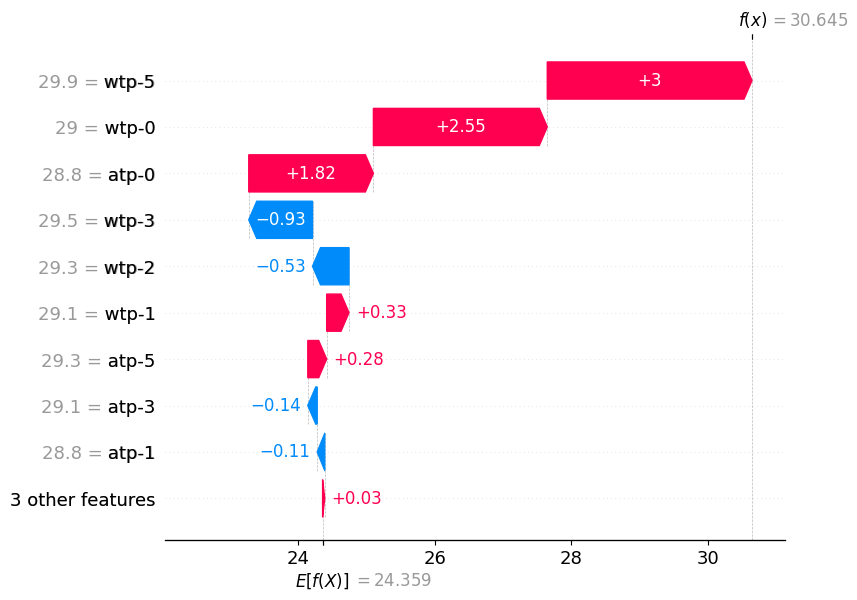

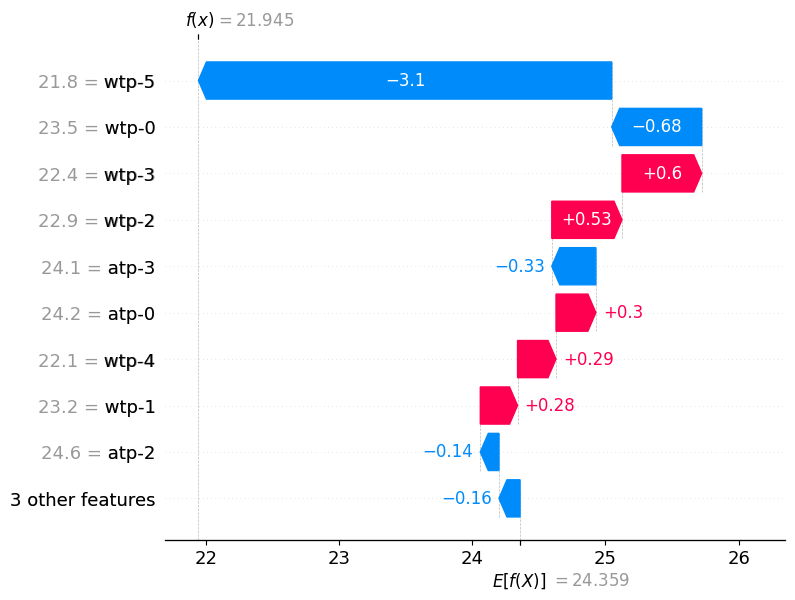

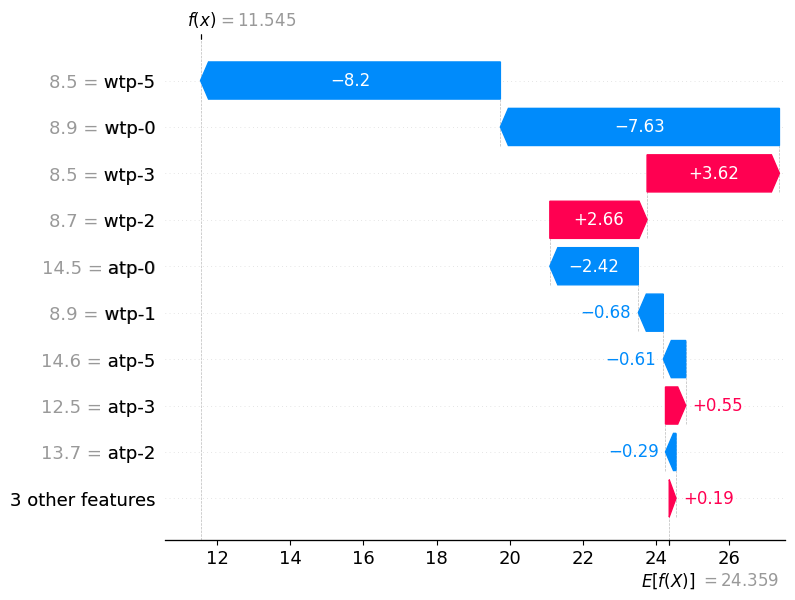

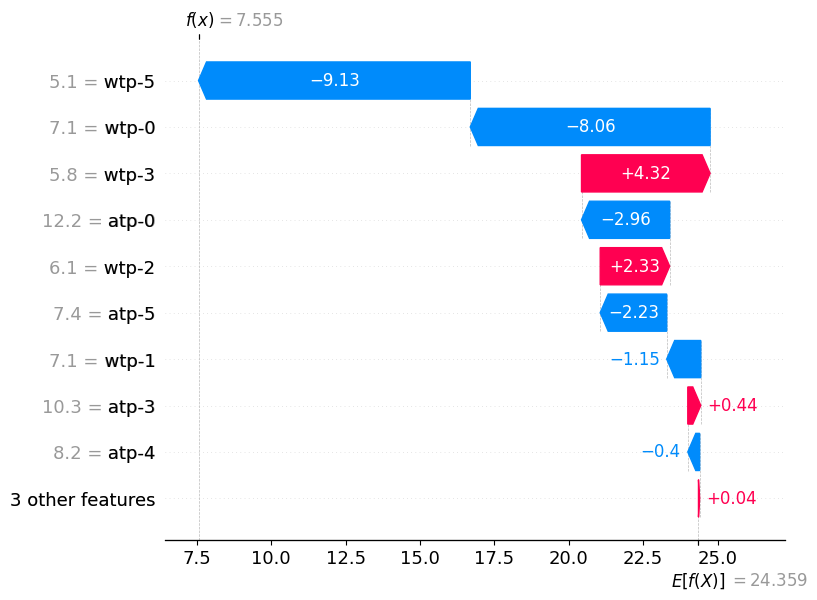

In [ ]:
# Explain middle
for i in range(n_plots):
  shap.plots.waterfall(explanation[middle_idxs[i]])

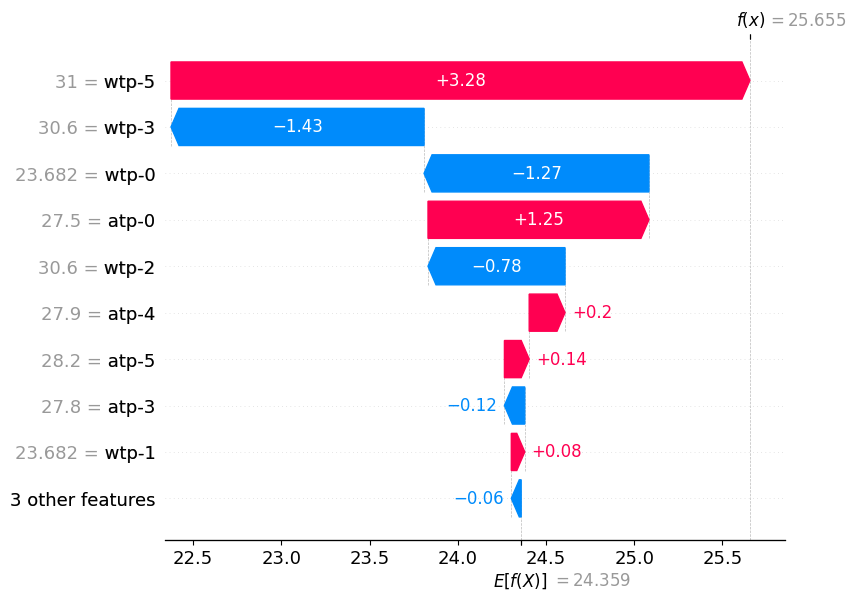

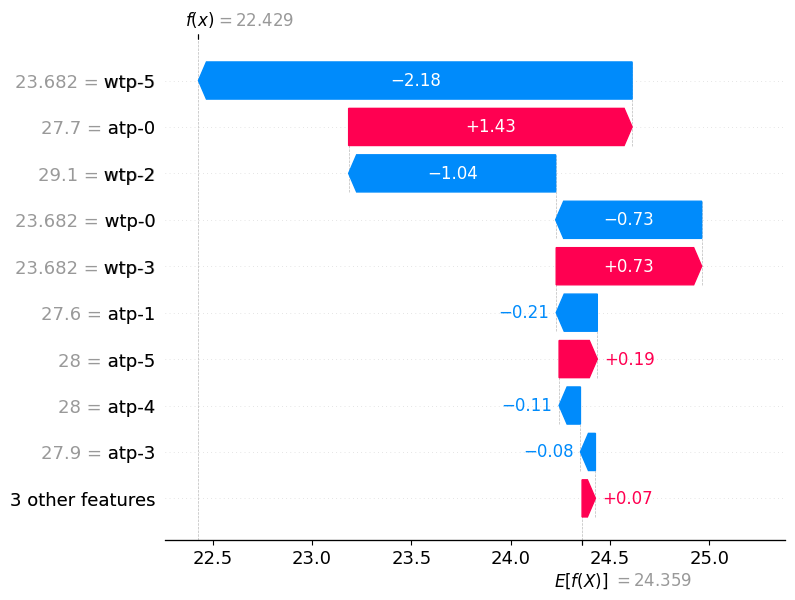

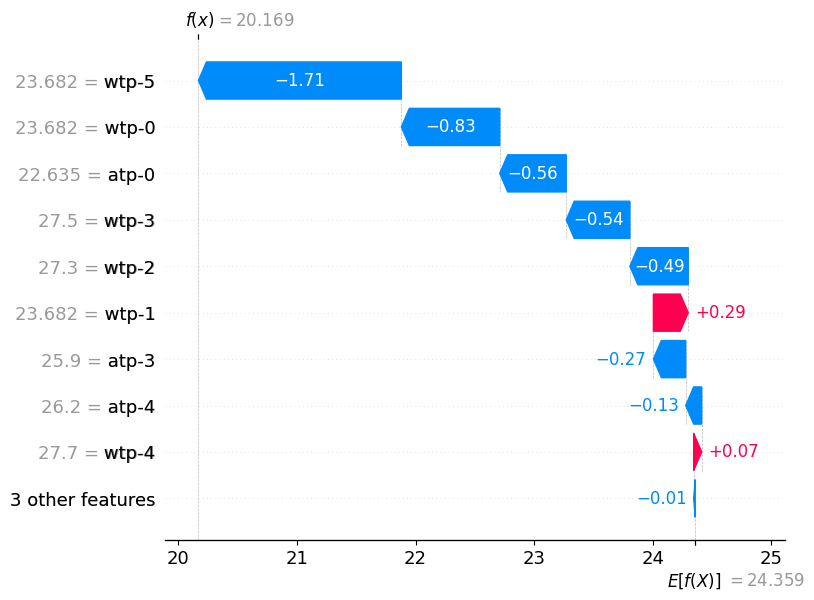

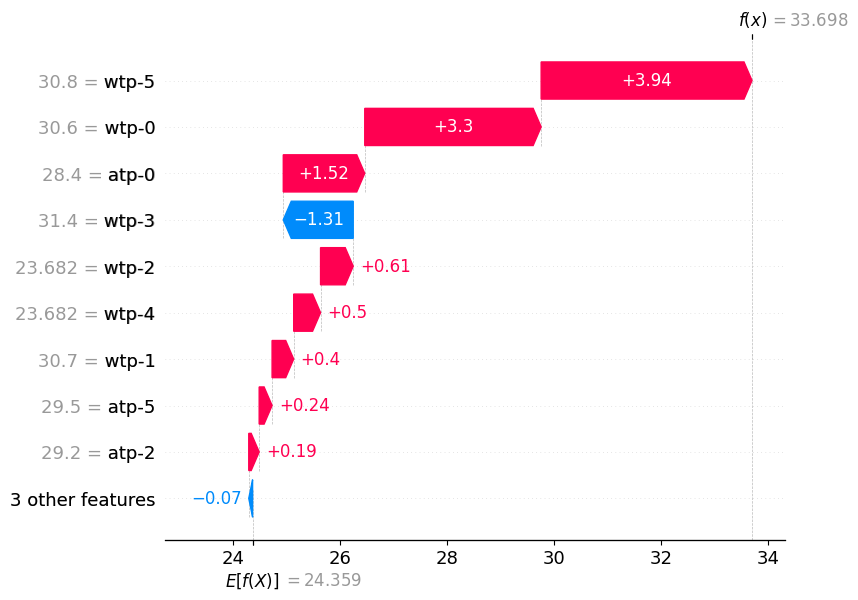

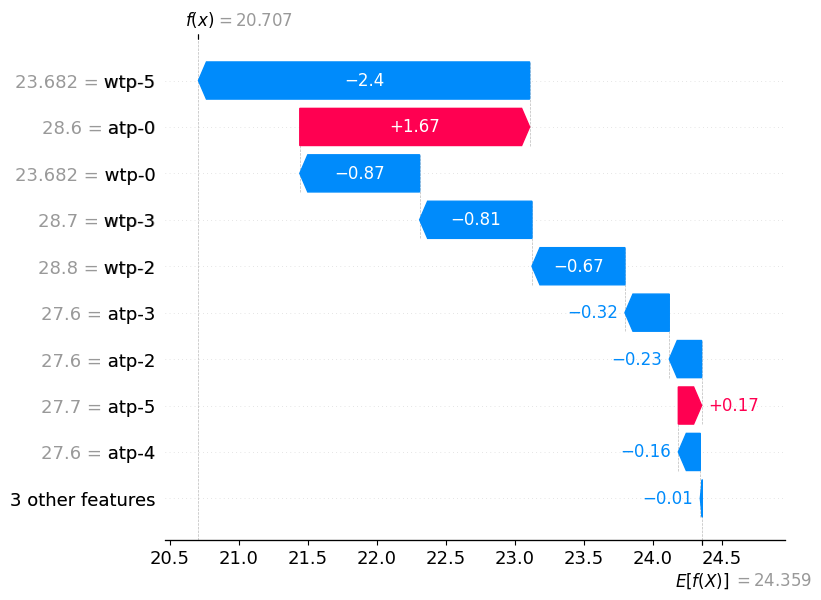

In [ ]:
# Explain worst
for i in range(n_plots):
  shap.plots.waterfall(explanation[worst_idxs[i]])